In [3]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import requests
import re
from datetime import date
import re
import torch
import matplotlib.pyplot as plt
from pacmap import PaCMAP
from transformers import AutoTokenizer, AutoModel
import arxiv
from sklearn.neighbors import KNeighborsTransformer
from IPython.display import clear_output
from datetime import date
from datetime import timedelta
from pymongo import MongoClient
from datetime import datetime
from torch import nn
device = 'cpu'
torch.device(device)

device(type='cpu')

In [2]:
queries_of_interest = ['computer science', 'computational biology']

In [4]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

def get_embedding(model, tokenizer, text):   
    encoded_input = tokenizer(text, padding=True, truncation=True, return_tensors='pt')

    # Compute token embeddings
    with torch.no_grad():
        model_output = model(**encoded_input)
    
    sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
    
    return sentence_embeddings.numpy()


def get_papers_after_date(last_date):
    search = arxiv.Search(
      query = "computer science",
      max_results = 1000,
      sort_by = arxiv.SortCriterion.SubmittedDate
    )
    
    
    tokenizer = AutoTokenizer.from_pretrained('allenai/longformer-base-4096')
    model = AutoModel.from_pretrained('allenai/longformer-base-4096')
    
    paper_data = []
    
    for result in search.results():
        ## To be changed
        paper_date = (result.published+timedelta(days=1)).date()
        ##
        
        
        if paper_date < last_date.date():
            break
        
        category_vector = [result.categories[i] if i<len(result.categories) else "Nafin" for i in range(3)]
        
        
        abstract = result.summary.replace('\n',' ').replace('\\&','').replace('\\%','')
        
        temp = [hash(result.title),result.title,result.published,abstract,result.pdf_url]
        temp.extend(category_vector)
        
        temp.append(get_embedding(model,tokenizer,result.title).tolist())
        temp.append(get_embedding(model,tokenizer,abstract).tolist())
        
        paper_data.append(temp)
        
    df = pd.DataFrame(data=paper_data, columns=['_id','Title','Date', 'Abstract',"PDF URL",'Category1','Category2','Category3',"TitleEmbedding","AbstractEmbedding"])
    
    return df

In [5]:
def get_papers_after_date(last_date):
    search = arxiv.Search(
      query = "computer science",
      max_results = 1000,
      sort_by = arxiv.SortCriterion.SubmittedDate
    )
    
    
    tokenizer = AutoTokenizer.from_pretrained('allenai/longformer-base-4096')
    model = AutoModel.from_pretrained('allenai/longformer-base-4096')
    
    paper_data = []
    
    for result in search.results():
        ## To be changed
        paper_date = (result.published+timedelta(days=1)).date()
        ##
        
        
        if paper_date < last_date.date():
            break
        
        category_vector = [result.categories[i] if i<len(result.categories) else "Nafin" for i in range(3)]
        
        
        abstract = result.summary.replace('\n',' ').replace('\\&','').replace('\\%','')
        
        temp = [hash(result.title),result.title,result.published,abstract,result.pdf_url]
        temp.extend(category_vector)
        
        temp.append(get_embedding(model,tokenizer,result.title).tolist())
        temp.append(get_embedding(model,tokenizer,abstract).tolist())
        
        paper_data.append(temp)
        
    df = pd.DataFrame(data=paper_data, columns=['_id','Title','Date', 'Abstract',"PDF URL",'Category1','Category2','Category3',"TitleEmbedding","AbstractEmbedding"])
    
    return df

In [6]:
def get_abstracts_by_ids(paper_index_map):
    inv_paper_map = {v: k for k, v in paper_index_map.items()}
    
    client = MongoClient('mongodb://localhost:27017/?readPreference=primary&appname=MongoDB%20Compass&ssl=false')
    
    # get all users recently viewed
    db = client.papers.papers
    
    all_viewed = list(db.find({"_id":{"$in":list(paper_index_map.keys())}},{"Abstract":1}))
    
    data = np.chararray(len(all_viewed),itemsize=10000)
    
    new_map = {}
    data = []
    for i in range(len(all_viewed)):
        paper_id = all_viewed[i]["_id"]
        new_map[paper_index_map[paper_id]] = i
        data.append(all_viewed[i]["Abstract"])
    
    return np.array(data),new_map

In [7]:
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

class ClickedDataset(Dataset):
    def __init__(self, abstracts, item_vectors,abstract_map):
        self.item_vectors = item_vectors.astype(np.float32)
        self.abstracts = abstracts
        self.abstract_map = abstract_map

    def __len__(self):
        return len(self.item_vectors)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        abstract = self.abstracts[self.abstract_map[idx]]
        item_vecs = self.item_vectors[idx]
        
        sample = (abstract,item_vecs)

        return sample    
    
class paperBERT(nn.Module):
    def __init__(self, latent_dim):
        super(paperBERT, self).__init__()
        self.longformer = AutoModel.from_pretrained('allenai/longformer-base-4096')
        self.tokenizer = AutoTokenizer.from_pretrained('allenai/longformer-base-4096')
        self.linear1 = nn.Linear(768, 256)
        self.linear2 = nn.Linear(256, latent_dim)
        
    def forward(self,data):
        encoding = self.tokenizer.batch_encode_plus(data, return_tensors='pt', padding=True,
                                                       truncation=True, add_special_tokens = True).to(device)
        input_ids = encoding['input_ids']
        attention_mask = encoding['attention_mask']
        
        model_output = self.longformer(
               input_ids, 
               attention_mask=attention_mask)

        # sequence_output has the following shape: (batch_size, sequence_length, 768)
        sequence_output=  mean_pooling(model_output, attention_mask)
        print(sequence_output.shape)
        linear1_output = self.linear1(sequence_output.view(-1,768)) ## extract the 1st token's embeddings
        linear2_output = self.linear2(linear1_output)

        return linear2_output
    
    def train(self,data_loader,epochs):
        criterion = nn.MSELoss() ## If required define your own criterion
        optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()))

        for epoch in range(epochs):
            for batch in data_loader: ## If you have a DataLoader()  object to get the data.
                
                data = list(batch[0])
                targets = batch[1] ## assuming that data loader returns a tuple of data and its targets
                
                optimizer.zero_grad()   
                outputs = model(data)
                outputs = torch.tanh(outputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
    
    @torch.no_grad()
    def predict(self, data):
        with torch.no_grad():
            encoding = self.tokenizer.batch_encode_plus(data, return_tensors='pt', padding=True,
                                                           truncation=True, add_special_tokens = True).to(device)
            input_ids = encoding['input_ids']
            attention_mask = encoding['attention_mask']

            model_output = self.longformer(
                   input_ids, 
                   attention_mask=attention_mask)

            # sequence_output has the following shape: (batch_size, sequence_length, 768)
            sequence_output=  mean_pooling(model_output, attention_mask)
            print(sequence_output.shape)
            linear1_output = self.linear1(sequence_output.view(-1,768)) ## extract the 1st token's embeddings
            linear2_output = self.linear2(linear1_output)
            outputs = torch.tanh(linear2_output)
        return outputs.numpy()

In [331]:
rat,user_index_map,paper_index_map = generate_interaction_matrix()

latent_dim = 10
MAX_ITERATION = 1000
TOLERANCE = 1e-4
U,P = approximate(rat, data_mask, latent_dim, 1)

abstracts,new_map = get_abstracts_by_ids(paper_index_map)
dataset = ClickedDataset(abstracts, P,new_map)
data_loader = DataLoader(dataset, batch_size=10,shuffle=True)

model = paperBERT(latent_dim) # You can pass the parameters if required to have more flexible model
model.to(device) ## can be gpu
#model.train(data_loader,5)

Start objective: 8320.143828725739
Converged: True
# iterations: 7
Final objective: 3.0


Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing LongformerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


paperBERT(
  (longformer): LongformerModel(
    (embeddings): LongformerEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(4098, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): LongformerEncoder(
      (layer): ModuleList(
        (0): LongformerLayer(
          (attention): LongformerAttention(
            (self): LongformerSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (query_global): Linear(in_features=768, out_features=768, bias=True)
              (key_global): Linear(in_features=768, out_features=768, bias=True)
              (value_global): Linear(in_feat

In [337]:
item_pred = model.predict(list(abstracts[:10]))

torch.Size([10, 768])


In [335]:
print(item_pred)

[[-0.2177798  -0.05733171 -0.10848948 -0.00063107  0.2178803   0.11466382
  -0.19518623 -0.04703917  0.24380101 -0.14298704]
 [-0.20309497 -0.02282331 -0.06286729 -0.05350485  0.19309942  0.10009719
  -0.1373236  -0.08971114  0.25474325 -0.15889482]
 [-0.22715926 -0.0660781  -0.08698583 -0.01901439  0.1952582   0.07186789
  -0.14948282 -0.06152859  0.25174576 -0.10831404]
 [-0.21838889 -0.03443026 -0.10312241 -0.00762006  0.23165008  0.13091125
  -0.17319335 -0.09733933  0.26188704 -0.17631511]
 [-0.20123059 -0.04940609 -0.08939983 -0.022474    0.24247847  0.10977195
  -0.17588036 -0.02207063  0.2010569  -0.16957085]
 [-0.23084119 -0.05561435 -0.09393923  0.01601766  0.19896518  0.1233958
  -0.18921125 -0.08285669  0.23452727 -0.13247065]
 [-0.20250373 -0.09292164 -0.12195797  0.00843132  0.16919988  0.16801114
  -0.1658791  -0.11104954  0.2974189  -0.15374184]
 [-0.23345332 -0.0564669  -0.12840258 -0.01150201  0.14443612  0.1369468
  -0.22225943 -0.13190164  0.26721305 -0.16708834]
 [

In [348]:
P[5],item_pred[5]

(array([ 0.00229371,  0.00803845,  0.00532361, -0.01641584, -0.00486945,
        -0.0027297 ,  0.00100707, -0.02019379,  0.00494651, -0.00947571]),
 array([-0.23084119, -0.05561435, -0.09393923,  0.01601766,  0.19896518,
         0.1233958 , -0.18921125, -0.08285669,  0.23452727, -0.13247065],
       dtype=float32))

In [344]:
rat[:,:10]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])

In [346]:
U,P = approximate(rat[:,:10], latent_dim, 1,Y_start=U,Z_start=item_pred)

Start objective: 185.05454309841716
Iteration: 10
Current objective: 1.2516780809886026
Iteration: 20
Current objective: 1.1921378457952398
Iteration: 30
Current objective: 1.162010818863975
Iteration: 40
Current objective: 1.1429230464085638
Iteration: 50
Current objective: 1.1294122630569963
Iteration: 60
Current objective: 1.1191880473810554
Iteration: 70
Current objective: 1.1110955862418266
Iteration: 80
Current objective: 1.1044800347032928
Iteration: 90
Current objective: 1.0989382654038415
Iteration: 100
Current objective: 1.0942065211469143
Iteration: 110
Current objective: 1.0901039104637258
Iteration: 120
Current objective: 1.0865016270398025
Iteration: 130
Current objective: 1.0833050967596234
Iteration: 140
Current objective: 1.08044308449734
Iteration: 150
Current objective: 1.0778607632734498
Iteration: 160
Current objective: 1.0755151464572579
Iteration: 170
Current objective: 1.073371985541284
Iteration: 180
Current objective: 1.071403607884214
Iteration: 190
Current o

In [347]:
P

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.00229371,  0.00803845,  0.00532361, -0.01641584, -0.00486945,
        -0.0027297 ,  0.00100707, -0.02019379,  0.00494651, -0.00947571],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        

In [8]:
def loss(X, Y, Z, mask, lam):
    return np.sum( ((Y.T @ Z - X) ** 2)[mask] ) \
       + lam * np.linalg.norm(Y, ord="fro") \
       + lam * np.linalg.norm(Z, ord="fro")

def approximate(data_dense, rank, lam,max_iteration=1000,Y_start=None,Z_start=None):
    # initialize low-rank approximation matrix as a product of two 
    # Y @ Z = X_bar
    data_mask = np.ones(data_dense.shape, dtype=np.bool)
    if Y_start is None and Z_start is None:
        Y = Y_start
        z = Z_start
    else:
        Y = np.random.randn(rank, data_dense.shape[0])
        Z = np.random.randn(rank, data_dense.shape[1])

    # calculation speedup
    lam_I = lam * np.eye(rank)

    # alternating least squares until convergence
    prev_obj = loss(data_dense, Y, Z, data_mask, lam)
    converged = False

    print("Start objective:", prev_obj)

    prev_Y = Y.copy()
    prev_Z = Z.copy()
    for iteration in range(1, max_iteration + 1):
        if iteration % 10 == 0:
            print("Iteration:", iteration)
            print("Current objective:", prev_obj)

        # optimize Y based on current value of Z
        for col in range(Y.shape[1]):
            has_rating = data_mask[col]
            ratings = data_dense[col, has_rating]
            Z_relevant_columns = Z[:, has_rating]
            regularized_cov = np.sum([c.reshape([-1, 1]) @ c.reshape([1, -1]) for
                                    c in Z_relevant_columns.T], axis=0) + lam_I
            weighted_sum = np.sum(Z_relevant_columns * ratings, axis=1)
            Y[:, col] = np.linalg.inv(regularized_cov) @ weighted_sum

        # optimize Z based on current values of Y
        for col in range(Z.shape[1]):
            has_rating = data_mask[:, col]
            ratings = data_dense[has_rating, col]
            Y_relevant_columns = Y[:, has_rating]
            regularized_cov = np.sum([c.reshape([-1, 1]) @ c.reshape([1, -1]) for
                                    c in Y_relevant_columns.T], axis=0) + lam_I
            weighted_sum = np.sum(Y_relevant_columns * ratings, axis=1)
            Z[:, col] = np.linalg.inv(regularized_cov) @ weighted_sum

        obj = loss(data_dense, Y, Z, data_mask, lam)

        # convergence criteria. prevents division by 0.
        if abs(obj - prev_obj) / ( abs(prev_obj) + 1e-8 ) < TOLERANCE:
            converged = True
            break

        prev_obj = obj

    print("Converged:", converged)
    print("# iterations:", iteration)
    print("Final objective:", obj)

    # report final low-rank matrix
    return Y.T, Z.T

In [174]:
def generate_interaction_matrix():
    client = MongoClient('mongodb://localhost:27017/?readPreference=primary&appname=MongoDB%20Compass&ssl=false')
    
    # get all users recently viewed
    db = client.papers.users
    
    all_viewed = db.find({},{"recently_viewed":1})
    users_viewed = list(all_viewed)
    
    # get all papers and their ids
    db = client.papers.papers
    
    all_paper_ids = db.find({},{"_id":1})
    all_ids = list(all_paper_ids)
    
    # make dictionary between paper id and index in array
    paper_index_map = {}
    
    i=0
    for dic in all_ids:
        paper_index_map[dic["_id"]] = i
        i+=1
    
    # make array of zeroes with shape (users,papers)
    clicked = np.zeros((len(users_viewed),len(all_ids)))
    
    # for all users recently viewed change 0 in array to a 1
    user_index_map = {}
    i=0
    for user in users_viewed:
        user_index_map[user["_id"]] = i
        
        for paper in user["recently_viewed"]:
            clicked[i,paper_index_map[paper]] = 1
        
        i+=1
    
    return clicked,user_index_map, paper_index_map

In [9]:
def get_last_two_weeks():
    client = MongoClient('mongodb://localhost:27017/?readPreference=primary&appname=MongoDB%20Compass&ssl=false')

    db = client.papers.users
    user = db.find_one({'_id':0})
    
    # Get paperst hat had been missed
    df = get_papers_after_date(datetime.now()-timedelta(days=14))
    
    # Add them to the database
    db=client.papers.papers
    db.insert_many(df.to_dict('records'))
    
    # Remove old papers
    db.delete_many({'Last_date':{'$lt' : last_date_updated-timedelta(days=14)}})
    
def get_last_days_papers():
    client = MongoClient('mongodb://localhost:27017/?readPreference=primary&appname=MongoDB%20Compass&ssl=false')

    # Get paperst hat had been missed
    df = get_papers_after_date(datetime.now()-timedelta(days=1))
    
    # Add them to the database
    db=client.papers.papers
    db.insert_many(df.to_dict('records'))
    
    # Remove old papers
    db.delete_many({'Last_date':{'$lt' : last_date_updated-timedelta(days=14)}})
    
def dummy_user():
    client = MongoClient('mongodb://localhost:27017/?readPreference=primary&appname=MongoDB%20Compass&ssl=false')
    db = client.papers.users
    db.insert_one({"_id":0,"last_date_updated":datetime.now(),"recently_viewed":[],
                   "papers_read":0,"average_title":[[0 for i in range(768)]],"average_abstract":[[0 for i in range(768)]],
                   "title_weights":[.5]})
    
def delete_docs():
    client = MongoClient('mongodb://localhost:27017/?readPreference=primary&appname=MongoDB%20Compass&ssl=false')
    db = client.papers.papers
    db.delete_many({})

In [55]:
delete_docs()
get_last_two_weeks()

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing LongformerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


NameError: name 'last_date_updated' is not defined

## Todo
Now i gotta start having an interaction with front end and backend

In [10]:
def get_data(query,max_results):
    search = arxiv.Search(
      query = query,
      max_results = max_results,
      sort_by = arxiv.SortCriterion.SubmittedDate
    )
    
    paper_data = []
    
    for result in search.results():
        category_vector = [result.categories[i] if i<len(result.categories) else "Nafin" for i in range(3)]
        
        
        abstract = result.summary.replace('\n',' ').replace('\\&','').replace('\\%','')
        
        temp = [result.title,result.published,abstract,result.pdf_url]
        temp.extend(category_vector)
        paper_data.append(temp)
        
    df = pd.DataFrame(data=paper_data, columns=['Title','Date', 'Abstract',"PDF URL",'Category1','Category2','Category3'])
    
    return df

In [15]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

def get_embeddings(df):
    model = AutoModel.from_pretrained('allenai/longformer-base-4096')
    tokenizer = AutoTokenizer.from_pretrained('allenai/longformer-base-4096')
    
    abstracts = df.Abstract.values
    abstracts = [str(a) for a in abstracts]
    
    encoded_input = tokenizer(abstracts, padding=True, truncation=True, return_tensors='pt')

    # Compute token embeddings
    with torch.no_grad():
        model_output = model(**encoded_input)
    
    sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
    
    return sentence_embeddings.numpy()

In [16]:
data = get_data("computer science",100)

In [17]:
embeddings = get_embeddings(data)

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing LongformerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [54]:
from sklearn.neighbors import BallTree
kdt = BallTree(embeddings)
dist, positions = kdt.query([embeddings[col==1].mean(axis=0)],k=5)


for p in positions:
    print("Close Papers: ")
    print()

    close_titles = data.Title.values[p]
    print(close_titles)

    val = input(" (-1-Exit)")
    if val == "-1":
        break

    clear_output()

Close Papers: 

['ANCER: Anisotropic Certification via Sample-wise Volume Maximization'
 'Score refinement for confidence-based 3D multi-object tracking'
 'Gradient-Based Quantification of Epistemic Uncertainty for Deep Object Detectors'
 'ViTGAN: Training GANs with Vision Transformers'
 'Deep Learning for Reduced Order Modelling and Efficient Temporal Evolution of Fluid Simulations']
 (-1-Exit)-1


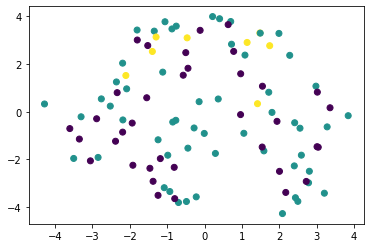

In [23]:
plt.scatter(result[:,0],result[:,1],c=col)

In [20]:
from sklearn.decomposition import PCA

In [42]:
def weightedL2(a,b):
    q = a-b
    return np.sqrt((weights*q*q).sum())

In [39]:
def show_closest_papers(df,embeddings,neighbors):
    titles,abstracts = df.Title.values, df.Abstract.values
    knt = KNeighborsTransformer(n_neighbors=neighbors)
    knt.fit(embeddings)
    A = knt.kneighbors_graph(embeddings).toarray()
    
    
    for i in range(df.shape[0]):
        print("Paper to compare: ", titles[i])
        print()
        print(abstracts[i])
        
        print()
        
        print("Other Papers: ")
        print()
        
        v = A[i]
        close_titles = data.Title.values[(v==1)]
        print(close_titles)
        
        val = input(" (-1-Exit)")
        if val == "-1":
            break

        clear_output()

In [37]:
pca = PCA(n_components=12)
pca_embeddings = pca.fit_transform(embeddings)

In [40]:
show_closest_papers(data,pca_embeddings,5)

Paper to compare:  Representation Consolidation for Training Expert Students

Traditionally, distillation has been used to train a student model to emulate the input/output functionality of a teacher. A more useful goal than emulation, yet under-explored, is for the student to learn feature representations that transfer well to future tasks. However, we observe that standard distillation of task-specific teachers actually *reduces* the transferability of student representations to downstream tasks. We show that a multi-head, multi-task distillation method using an unlabeled proxy dataset and a generalist teacher is sufficient to consolidate representations from task-specific teacher(s) and improve downstream performance, outperforming the teacher(s) and the strong baseline of ImageNet pretrained features. Our method can also combine the representational knowledge of multiple teachers trained on one or multiple domains into a single model, whose representation is improved on all teacher

In [41]:
import tensorflow as tf

In [43]:
weights = np.random.uniform(size=(12))

In [44]:
weights

array([0.8195742 , 0.62438009, 0.6366399 , 0.06499433, 0.19564744,
       0.52409539, 0.36947022, 0.97009038, 0.84978595, 0.87923217,
       0.36252663, 0.55420074])

In [ ]:
def curate_results_beta(embeddings,average_title,average_abstract,title_weights,num_papers):
    ids = [e["_id"] for e in embeddings]
    title_embeddings = [e["TitleEmbedding"][0] for e in embeddings]
    abstract_embeddings = [e["AbstractEmbedding"][0] for e in embeddings]
    
    ## Get closest title embeddings
    title_tree = BallTree(np.array(title_embeddings))
    title_dist, title_positions = title_tree.query(average_title,k=100)
    title_dist, title_positions = title_dist[0].tolist(), title_positions[0].tolist()
    
    ## Get closest abstract embeddings
    abstract_tree = BallTree(np.array(abstract_embeddings))
    abstract_dist, abstract_positions = abstract_tree.query(average_abstract,k=100)
    abstract_dist, abstract_positions = abstract_dist[0].tolist(), abstract_positions[0].tolist()
    
    # Get random weights
    if num_papers > 10:
        bandwith = (1/(len(title_weights)))/10
        kde = KernelDensity(bandwidth=bandwith).fit(title_weights)
        sampled_title_weights = kde.sample(len(title_embeddings))
        sampled_title_weights[sampled_title_weights<0] = 0
        sampled_title_weights[sampled_title_weights>1] = 1
    else:
        sampled_title_weights = np.full((len(title_embeddings),1),.5)
    
    ## Compute distances
    combined = {}
    weights = {}
    for i in range(100):
        # add title vector
        e = title_positions[i]
        weights[ids[e]] = sampled_title_weights[i]
        if e not in combined:
            combined[ids[e]] = title_dist[i]*sampled_title_weights[i]
        else:
            combined[ids[e]] += title_dist[i]
            
        # add abstract vector
        e = abstract_positions[i]
        
        if ids[e] not in weights:
            weights[ids[e]] = sampled_title_weights[i]
        
        if e not in combined:
            combined[ids[e]] = abstract_dist[i]*(1-sampled_title_weights[i])
        else:
            combined[ids[e]] += abstract_dist[i]*(1-sampled_title_weights[i])
    
    ## Sort by lowest distance
    combined_dist = [(k,v) for k,v in combined.items()]
    combined_dist = sorted(combined_dist,key=lambda t: t[1])
    return [c[0] for c in combined_dist], weights


In [81]:
def get_popular_papers():
    client = MongoClient('mongodb://localhost:27017/?readPreference=primary&appname=MongoDB%20Compass&ssl=false')

    db = client.papers.papers
    papers = db.find({"date" : {"$gt": datetime.now()-timedelta(days=2)}},{"title":1,
                                                                          "abstract":1,
                                                                          "date":1,
                                                                          "number_of_clicks":1})
    
    paper_list = []
    
    for p in list(papers):
        paper_list.append((p["_id"],p["number_of_clicks"]))
        
    paper_list = sorted(paper_list, key=lambda t: t[1],reverse=True)
    papers = db.find({"_id": {"$in" : [t[0] for t in paper_list[:4]]}})
    return list(papers)

In [82]:
get_popular_papers()

[{'_id': -1319214656870171062,
  'title': 'Classical Theory of Quantum Work Distribution in Chaotic Fermion Systems',
  'date': datetime.datetime(2021, 7, 21, 17, 47, 25),
  'abstract': "We present a theory of quantum work statistics in generic chaotic, disordered Fermi liquid systems within a driven random matrix formalism. By extending P. W. Anderson's orthogonality determinant formula to compute quantum work distribution, we find that work statistics is non-Gaussian and is characterized by a few dimensionless parameters. At longer times, quantum interference effects become irrelevant and the quantum work distribution is well-described in terms of a purely classical ladder model with a symmetric exclusion process in energy space, while bosonization and mean field methods provide accurate analytical expressions for the work statistics. Our random matrix and mean field predictions are validated by numerical simulations for a two-dimensional disordered quantum dot, and can be verified b